In [1]:
#Loading the packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import seaborn as sns

from mlxtend.feature_selection import ExhaustiveFeatureSelector

import xgboost as xgb

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

# Milestone 1
Preprocessing of raw data

## Loading the main dataset

In [2]:
data = pd.read_csv('H2HBABBA1626.csv')
data.shape

(50000, 19)

## spliting the main data into main test and main train

In [3]:
test = data[data['clear_date'].isnull()].to_csv('final_test.csv', index=False)
train = data[~data['clear_date'].isnull()].to_csv('train.csv', index=False)

In [4]:
#read train csv
data = pd.read_csv('train.csv')
df=pd.DataFrame(data)
df.shape

(40000, 19)

#### Removing the null columns
Here I am checking for null columns, if found I can drop them.

In [5]:
df.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                    0
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             40000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    3
isOpen                        0
dtype: int64

##### area_business column is totally null as we can see.
So we can drop it.

In [6]:
df.drop(['area_business'], axis=1, inplace=True)

In [7]:
df.shape

(40000, 18)

##### Now we have removed the null columns, we have to check for constant columns.
Now inorder to check for constant columns, we are going to use VarianceThreshold() of sklearn. It uses only int and float values so we have to drop the string columns for this step.

In [8]:
df.drop('business_code', axis=1, inplace=True)
df.drop('name_customer', axis=1, inplace=True)
df.drop('cust_payment_terms', axis=1, inplace=True)
df.drop('invoice_currency', axis=1, inplace=True)
df.drop('document type', axis=1, inplace=True)
df.drop('cust_number', axis=1, inplace=True)

##### We have to convert due_in_date and clear_date to int type as well.

In [9]:
df['posting_date'] = pd.to_datetime(df['posting_date']).astype(np.int64)
df['clear_date'] = pd.to_datetime(df['clear_date']).astype(np.int64) 

In [10]:
[col for col in df.columns if df[col].isnull().sum() > 0]

['invoice_id']

##### Now applying the VarianceThreshold() with threshold=0.
It implies that variance of all the data in the column are same/constant.

In [11]:
sel = VarianceThreshold(threshold=0)
sel.fit(df)

VarianceThreshold(threshold=0)

In [12]:
sum(sel.get_support())

10

##### Now to check the columns which were constant

In [13]:
print(
    len([
        x for x in df.columns
        if x not in df.columns[sel.get_support()]
    ]))

[x for x in df.columns if x not in df.columns[sel.get_support()]]

2


['posting_id', 'isOpen']

##### So these two columns are having constant values,
so we can drop them. posting_id and isOpen column are having the same data throughout the dataset. There's no point in feeding constant data to our model. So we can drop these columns from our dataset.

In [14]:
#now droping those columns
df.drop('posting_id', axis=1, inplace=True)
df.drop('isOpen', axis=1, inplace=True)

#### Now we check for QuasiConstant columns.
By simply passing threshold=0.02 in VarianceThreshold function. It implies that variance of 98% of the data in the column are same/constant.

In [15]:
sel = VarianceThreshold(threshold=0.02)
sel.fit(df)

VarianceThreshold(threshold=0.02)

In [16]:
sum(sel.get_support())

10

In [17]:
print(
    len([
        x for x in df.columns
        if x not in df.columns[sel.get_support()]
    ]))

[x for x in df.columns if x not in df.columns[sel.get_support()]]

0


[]

##### We see we have 0 quasi constant columns. 
So we dont need to drop any column in this step.

#### Now we know we have 2 constant columns posting_id and isOpen. 
So we can remove them from our dataset. So lets load the dataset.

In [18]:
data = pd.read_csv('train.csv')
df = pd.DataFrame(data)
df.shape

(40000, 19)

In [19]:
df.nunique()

business_code                 6
cust_number                1373
name_customer              3949
clear_date                  396
buisness_year                 2
doc_id                    39118
posting_date                423
document_create_date        427
document_create_date.1      423
due_in_date                 493
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         35678
baseline_create_date        435
cust_payment_terms           72
invoice_id                39115
isOpen                        1
dtype: int64

In [20]:
# Removing the null column and constant columns which we found from above steps
df.drop('area_business', axis=1, inplace=True)  #Null column
df.drop('posting_id', axis=1, inplace=True)  #constant column
df.drop('isOpen', axis=1, inplace=True)  #constant column

##### Renaming some columns for our convention

In [21]:
df = df.rename(columns= {'document type': 'doc_type'} )
df = df.rename(columns= {'document_create_date.1': 'doc_create_date'} )
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09


#### Checking for any duplicate data in rows

In [22]:
data_t = df.T
data_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,...,39875,39876,39877,39878,39879,39880,39881,39882,39883,39884,39885,39886,39887,39888,39889,39890,39891,39892,39893,39894,39895,39896,39897,39898,39899,39900,39901,39902,39903,39904,39905,39906,39907,39908,39909,39910,39911,39912,39913,39914,39915,39916,39917,39918,39919,39920,39921,39922,39923,39924,39925,39926,39927,39928,39929,39930,39931,39932,39933,39934,39935,39936,39937,39938,39939,39940,39941,39942,39943,39944,39945,39946,39947,39948,39949,39950,39951,39952,39953,39954,39955,39956,39957,39958,39959,39960,39961,39962,39963,39964,39965,39966,39967,39968,39969,39970,39971,39972,39973,39974,39975,39976,39977,39978,39979,39980,39981,39982,39983,39984,39985,39986,39987,39988,39989,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
business_code,U001,CA02,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U002,U001,U001,U001,U001,U001,U001,U002,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,CA02,U001,U001,U001,CA02,...,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U013,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,CA02,U001,CA02,U001,U001,U001,U001,U001,U013,U001,U001,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U013,U001,CA02,CA02,U001,U001,CA02,CA02,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001,U001
cust_number,0200726979,140104423,0200744019,0200759878,0200769623,0140104440,0200769623,CCCA02,0200769623,0200777735,0200781803,0200793568,0200785971,0200833713,0200759878,0200705742,200707822,0200466603,0200020431,0200290370,0140105847,0200769623,0200793568,200706844,0200416837,0200769623,0200512145,0100034821,0200078854,0200761734,0200274078,0200761734,0200726979,0200772670,200769623,0200555117,0140104265,0200769623,0200792293,0200772595,0100030964,200793513,0140104429,0200706844,CCU013,0100000533,0200726979,CCCA02,0200769623,0200748108,0200762301,0200769623,0200793568,0200792293,200881076,200769623,0200980828,0200900909,0200519201,0200769623,0200353024,0200769623,0200783190,0200782001,0200794332,0200799342,0200794332,0200739941,0200769623,200769623,0200705742,0140104409,0200253680,0200762301,0200763229,0200769623,0200744707,0200769623,200198605,0200794332,200776463,0200793513,0200769623,0200729942,0200769623,0200705742,0200799538,0200762301,0200794332,0200769623,CCU013,0200726979,0200759878,0200706844,0200418007,0200758883,0200761734,0200416837,0200769623,0200762301,0200978592,0200761734,0200707822,0200707741,200782001,0200763814,200794332,200816950,0200726979,200407025,200148860,0200769623,200794332,0200965912,0200762301,0200550425,0200726979,0200726979,200759878,0140104429,0140104429,0200769623,0200769623,0200735528,0140104429,...,0200769623,0200439158,0200769623,0200706844,0200769623,0200705372,0100031704,0200416837,0200707005,0200759878,0200769623,0100031704,0200769623,0200769623,0140106408,0200197349,0200795490,0200803720,0200799367,0200290370,020072994

In [23]:
data_t.duplicated().sum()

0

##### I have no duplicate data in my rows so I can continue working on the model with df dataframe.

In [24]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09


##### Checking for any null value in our rows

In [25]:
df.isnull().sum()

business_code           0
cust_number             0
name_customer           0
clear_date              0
buisness_year           0
doc_id                  0
posting_date            0
document_create_date    0
doc_create_date         0
due_in_date             0
invoice_currency        0
doc_type                0
total_open_amount       0
baseline_create_date    0
cust_payment_terms      0
invoice_id              3
dtype: int64

##### We have 3 null data in invoice_id which are null.
Since its invoice_id, its almost unique to every customer. So we can't impute any data into the null row. So, we have can drop it.

In [26]:
df[df['invoice_id'].isna()] #checked the rows which have NaN and removed it in the following cell

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id
14611,CA02,0140104429,COSTCO foundation,2019-05-02 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190306,20190316.0,CAD,X2,52992.00,20190306.0,CA10,NaN
31131,CA02,0140104409,LOB trust,2019-05-31 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190307,20190317.0,CAD,X2,17264.88,20190307.0,CA10,NaN
34483,CA02,0140104429,COSTCO co,2019-05-02 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190227,20190309.0,CAD,X2,52992.00,20190227.0,CA10,NaN


In [27]:
df = df.drop(df.index[[14611, 31131, 34483]])

In [28]:
df.dtypes #checking the dtypes

business_code            object
cust_number              object
name_customer            object
clear_date               object
buisness_year           float64
doc_id                  float64
posting_date             object
document_create_date      int64
doc_create_date           int64
due_in_date             float64
invoice_currency         object
doc_type                 object
total_open_amount       float64
baseline_create_date    float64
cust_payment_terms       object
invoice_id              float64
dtype: object

### Now lets add the target column.
We need to find delay made by finding the difference between clear_date and posting_date. That is, after how many days payment was made. First we need to convert the clear_date and posting_date column's datatype to pandas datetime object.

##### Converting the clear_date and due_in_date into datetime object of pandas 

In [29]:
df.dtypes

business_code            object
cust_number              object
name_customer            object
clear_date               object
buisness_year           float64
doc_id                  float64
posting_date             object
document_create_date      int64
doc_create_date           int64
due_in_date             float64
invoice_currency         object
doc_type                 object
total_open_amount       float64
baseline_create_date    float64
cust_payment_terms       object
invoice_id              float64
dtype: object

In [30]:
df['clear_date_pd'] = pd.to_datetime(df['clear_date'])
df['due_date_pd'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['post_date_pd'] = pd.to_datetime(df['posting_date'])

In [31]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09,2019-08-01,2019-07-31,2019-07-16
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09,2019-04-09,2019-04-10,2019-03-29
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09,2019-03-11,2019-03-07,2019-02-20
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09,2019-04-30,2019-04-27,2019-04-12
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09,2020-02-04,2020-02-01,2020-01-17


##### Here actual_delay is the delay made, i.e., when the payment was done. This is our target column. Difference between clear_date and posting_date.

##### Whereas expected_delay is the delay in which the payment was supposed to happen. Difference in due_date and posting_date.

In [32]:
df['actual_delay'] = df['clear_date_pd'] - df['post_date_pd']
df['expected_delay'] = df['due_date_pd'] - df['post_date_pd']

In [33]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09,2019-08-01,2019-07-31,2019-07-16,16 days,15 days
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09,2019-04-09,2019-04-10,2019-03-29,11 days,12 days
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09,2019-03-11,2019-03-07,2019-02-20,19 days,15 days
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09,2019-04-30,2019-04-27,2019-04-12,18 days,15 days
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09,2020-02-04,2020-02-01,2020-01-17,18 days,15 days


##### Now I am converting both the delays to int type for further procedures.

In [34]:
# converting the delay columns to int first
df['actual_delay'] = df.actual_delay.astype('timedelta64[D]').astype(int)
df['expected_delay'] = df.expected_delay.astype('timedelta64[D]').astype(int)
df.dtypes

business_code                   object
cust_number                     object
name_customer                   object
clear_date                      object
buisness_year                  float64
doc_id                         float64
posting_date                    object
document_create_date             int64
doc_create_date                  int64
due_in_date                    float64
invoice_currency                object
doc_type                        object
total_open_amount              float64
baseline_create_date           float64
cust_payment_terms              object
invoice_id                     float64
clear_date_pd           datetime64[ns]
due_date_pd             datetime64[ns]
post_date_pd            datetime64[ns]
actual_delay                     int32
expected_delay                   int32
dtype: object

In [35]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09,2019-08-01,2019-07-31,2019-07-16,16,15
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09,2019-04-09,2019-04-10,2019-03-29,11,12
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09,2019-03-11,2019-03-07,2019-02-20,19,15
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09,2019-04-30,2019-04-27,2019-04-12,18,15
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09,2020-02-04,2020-02-01,2020-01-17,18,15


#### Here I added the age_bucket column i.e., range of delay in categories such as 0-15, 16-30, etc.
I used it as feature below but later decided to remove it as in the main test we dont have any clear_date column to find this age_bucket. 

##### Lets create a column age_bucket, which will show the range of delay. Ex- 0-15 days, 16-30 days......

In [36]:
# bins = [0,15,30,45,60, 1000]   #6 elements
# category = ["0-15 days", "16-30 days", "31-45 days", "46-60 days", "Greater than 60 days"]  #5 elements
# df['age_bucket'] = pd.cut(df["delay"],bins,labels = category)

#### Now we can fill the NaN values in age_bucket column with "0-15 days"

In [37]:
# df["age_bucket"].fillna('0-15 days', inplace = True)

##### Lastly we need to convert age_bucket column into string 

In [38]:
# df['age_bucket'] = df.age_bucket.astype(str)

In [39]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
0,U001,0200726979,BJ'S systems,2019-08-01 00:00:00,2019.0,1.929620e+09,2019-07-16,20190715,20190716,20190731.0,USD,RV,117.62,20190716.0,NAA8,1.929620e+09,2019-08-01,2019-07-31,2019-07-16,16,15
1,CA02,140104423,METRO foundation,2019-04-09 00:00:00,2019.0,2.960538e+09,2019-03-29,20190329,20190329,20190410.0,CAD,RV,136973.30,20190331.0,CA10,2.960538e+09,2019-04-09,2019-04-10,2019-03-29,11,12
2,U001,0200744019,TARG in,2019-03-11 00:00:00,2019.0,1.928814e+09,2019-02-20,20190218,20190220,20190307.0,USD,RV,19698.38,20190220.0,NAA8,1.928814e+09,2019-03-11,2019-03-07,2019-02-20,19,15
3,U001,0200759878,SA llc,2019-04-30 00:00:00,2019.0,1.929137e+09,2019-04-12,20190412,20190412,20190427.0,USD,RV,23026.93,20190412.0,NAH4,1.929137e+09,2019-04-30,2019-04-27,2019-04-12,18,15
4,U001,0200769623,WAL-MAR co,2020-02-04 00:00:00,2020.0,1.930412e+09,2020-01-17,20200118,20200117,20200201.0,USD,RV,31397.26,20200117.0,NAH4,1.930412e+09,2020-02-04,2020-02-01,2020-01-17,18,15


# Milestone 2
Feature Engineering 

#### Now lets start with spliting our data into train, test and validation set
For that we need to sort our data first in ascending order, then we will split them

In [40]:
sorted_df = df.sort_values(by = 'posting_date', ascending=True)

In [41]:
sorted_df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
25922,CA02,0140104423,METRO us,2019-01-15 00:00:00,2019.0,2.960520e+09,2018-12-30,20181230,20181230,20190113.0,CAD,RV,23464.08,20190103.0,CA10,2.960520e+09,2019-01-15,2019-01-13,2018-12-30,16,14
25733,U001,0200769623,WAL-MAR foundation,2019-01-10 00:00:00,2019.0,1.928544e+09,2018-12-30,20181230,20181230,20190114.0,USD,RV,1451.69,20181230.0,NAH4,1.928544e+09,2019-01-10,2019-01-14,2018-12-30,11,15
6517,U001,0200769623,WAL-MAR corporation,2019-01-15 00:00:00,2019.0,1.928541e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,12190.97,20181230.0,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,16,15
29817,U001,0200769623,WAL-MAR trust,2019-01-15 00:00:00,2019.0,1.928541e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,20718.81,20181230.0,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,16,15
3870,U001,0200762301,C&S WH associates,2019-01-15 00:00:00,2019.0,1.928540e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,3204.34,20181230.0,NAC6,1.928540e+09,2019-01-15,2019-01-14,2018-12-30,16,15


In [42]:
sorted_df.tail()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
27475,U001,0200707005,KING S co,2020-03-12 00:00:00,2020.0,1.930562e+09,2020-02-26,20200224,20200226,20200312.0,USD,RV,126138.95,20200226.0,NAA8,1.930562e+09,2020-03-12,2020-03-12,2020-02-26,15,15
21466,U001,0200705742,DOT foundation,2020-03-12 00:00:00,2020.0,1.930574e+09,2020-02-26,20200226,20200226,20200317.0,USD,RV,26382.14,20200226.0,NAD1,1.930574e+09,2020-03-12,2020-03-17,2020-02-26,15,20
18504,U001,0200769623,WAL-MAR,2020-03-09 00:00:00,2020.0,1.930567e+09,2020-02-26,20200225,20200226,20200312.0,USD,RV,52632.28,20200226.0,NAH4,1.930567e+09,2020-03-09,2020-03-12,2020-02-26,12,15
3750,U001,0100004536,BAS systems,2020-03-12 00:00:00,2020.0,1.930571e+09,2020-02-27,20200226,20200227,20200313.0,USD,RV,18509.90,20200227.0,NAA8,1.930571e+09,2020-03-12,2020-03-13,2020-02-27,14,15
25684,U001,0200721330,PARK corp,2020-03-12 00:00:00,2020.0,1.930577e+09,2020-02-27,20200227,20200227,20200308.0,USD,RV,77434.89,20200227.0,NA10,1.930577e+09,2020-03-12,2020-03-08,2020-02-27,14,10


##### The index of the data has been altered because of sorting so let's fix that first

In [43]:
sorted_df = sorted_df.reset_index(drop = True)

##### Here I will club customer payment terms.
The ones with very less frequency I will club them together into one group i.e., 'OTHERS'

In [44]:
sorted_df['cust_payment_terms'].value_counts()

NAA8    16118
NAH4    10482
CA10     3146
NAC6     1336
NAM4     1081
NAAX      907
NAD1      773
NAG2      739
NAU5      713
NAGD      646
NA32      623
NAX2      564
NAM2      424
NA10      395
NAD5      283
NAVE      256
NAM1      242
NAVF      204
NAAW      181
NAWU      127
NAVQ       91
NAWN       88
NAVR       78
NAWP       63
NAVM       41
NAUZ       40
NA3B       33
CA30       32
NABG       29
NA38       28
NACB       28
NAB1       21
NA84       20
C106       19
NA9X       15
NAD4       11
NA3F       11
BR56       10
NA8Q       10
NAVL       10
NAVD        7
CAB1        7
NAVC        6
NAUP        4
NATZ        4
NAD8        4
CA60        3
NAUI        3
NAM3        3
NATH        3
90M7        3
NATW        3
CAX2        3
NAV2        2
NA25        2
NATX        2
NATV        2
NAUN        2
BR12        2
NATL        2
NAUW        1
B112        1
NAV9        1
NATM        1
NAWM        1
BR60        1
NATK        1
C129        1
NA31        1
NANC        1
NATU        1
NA24  

In [45]:
# clubbing cust_payment_terms with low occurance in dataset - to ensure model gets max information
sorted_df['cust_payment_terms'] = np.where(sorted_df['cust_payment_terms']
                                .isin(["B112", "BR60", "NAV9", "NATM", "NAWM", "NANC", "NATU", "NA31"
                                , "NATK", "C129", "NA24", "NAUW", "BR12", "NAV2", "NATL", "CA60", "NA25"
                                , "NAUN", "NATV", "NATX", "CAX2", "NATH", "NAUI", "90M7", "NAM3", "NAD8"
                                , "NATZ", "NAUP", "NAVC", "CAB1", "NAVD", "BR56", "NAVL", "NA8Q", "NA3F"
                                , "NAD4", "NA9X", "C106", "NA84", "NAB1", "NATW", "NA38", "NACB", "NABG"
                                , "CA30", "NA3B", "NAUZ", "NAVM", "NAWN", "NAVQ", "NAWP", "NAVR", "NAWU"
                                , "NAAW", "NAVF", "NAD5", "NA10", "NAM2", "NAX2", "NA32", "NAM1", "NAVE"])
                                ,"OTHERS", 
                                sorted_df['cust_payment_terms'])

##### Checking the correlation between columns

In [46]:
sorted_df.corr()

,buisness_year,doc_id,document_create_date,doc_create_date,due_in_date,total_open_amount,baseline_create_date,invoice_id,actual_delay,expected_delay
buisness_year,1.000000,-0.004928,0.946416,0.962606,0.977630,-0.002295,0.964174,-0.004928,-0.006148,0.004096
doc_id,-0.004928,1.000000,-0.000418,-0.003833,-0.007196,0.195029,0.001473,1.000000,0.038513,-0.094993
document_create_date,0.946416,-0.000418,1.000000,0.983342,0.939967,0.001637,0.980646,-0.000418,-0.010496,0.002249
doc_create_date,0.962606,-0.003833,0.983342,1.000000,0.954671,-0.000773,0.997268,-0.003833,-0.009547,0.003345
due_in_date,0.977630,-0.007196,0.939967,0.954671,1.000000,-0.002193,0.957136,-0.007196,-0.009363,0.020641
total_open_amount,-0.002295,0.195029,0.001637,-0.000773,-0.002193,1.000000,0.000450,0.195029,-0.041864,-0.063107
baseline_create_date,0.964174,0.001473,0.980646,0.997268,0.957136,0.000450,1.000000,0.001473,-0.008874,0.007833
invoice_id,-0.004928,1.000000,-0.000418,-0.003833,-0.007196,0.195029,0.001473,1.000000,0.038513,-0.094993
actual_delay,-0.006148,0.038513,-0.010496,-0.009547,-0.009363,-0.041864,-0.008874,0.038513,1.000000,0.600067
expected_delay,0.004096,-0.094993,0.002249,0.003345,0.020641,-0.063107,0.007833,-0.094993,0.600067,1.000000


#### Checking for correlation
Here invoice_id and doc_id have a corelation 1.0
It means both columns have same values, so we can drop one of them.

baseline_create_date, document_create_date and document_create_date_norm also have correlation of 0.98 as well. We can keep only one of them.

We can drop name_customer also. 
document_type because it has all same values as 'RV'. 

In [47]:
sorted_df.drop('doc_id', axis=1, inplace=True)  #Duplicate column
sorted_df.drop('baseline_create_date', axis=1, inplace=True)  
sorted_df.drop('document_create_date', axis=1, inplace=True)  
sorted_df.drop('name_customer', axis=1, inplace=True)  
sorted_df.drop('doc_type', axis=1, inplace=True)  #Constant column
sorted_df.head()

,business_code,cust_number,clear_date,buisness_year,posting_date,doc_create_date,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,actual_delay,expected_delay
0,CA02,0140104423,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190113.0,CAD,23464.08,CA10,2.960520e+09,2019-01-15,2019-01-13,2018-12-30,16,14
1,U001,0200769623,2019-01-10 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,1451.69,NAH4,1.928544e+09,2019-01-10,2019-01-14,2018-12-30,11,15
2,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,12190.97,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,16,15
3,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,20718.81,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,16,15
4,U001,0200762301,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,3204.34,NAC6,1.928540e+09,2019-01-15,2019-01-14,2018-12-30,16,15


##### Separating the target column for test_train_split

In [48]:
X = sorted_df.drop(['actual_delay'], axis=1)
y = sorted_df['actual_delay']
X.shape, y.shape

((39997, 15), (39997,))

In [49]:
X_train, X_test_ini, y_train, y_test_ini = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [50]:
X_val, X_test, y_val, y_test = train_test_split(X_test_ini, y_test_ini, test_size=0.50, random_state=0, shuffle=False)

In [51]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((31997, 15), (4000, 15), (4000, 15), (31997,), (4000,), (4000,))

<AxesSubplot:xlabel='actual_delay', ylabel='Density'>

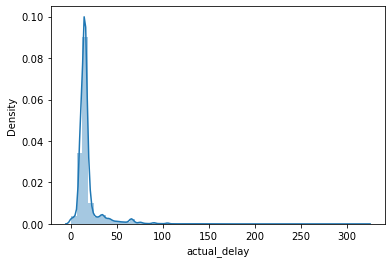

In [52]:
sns.distplot(y_train) 

##### Graph of targert column is slightly right skewed.

<AxesSubplot:xlabel='business_code', ylabel='actual_delay'>

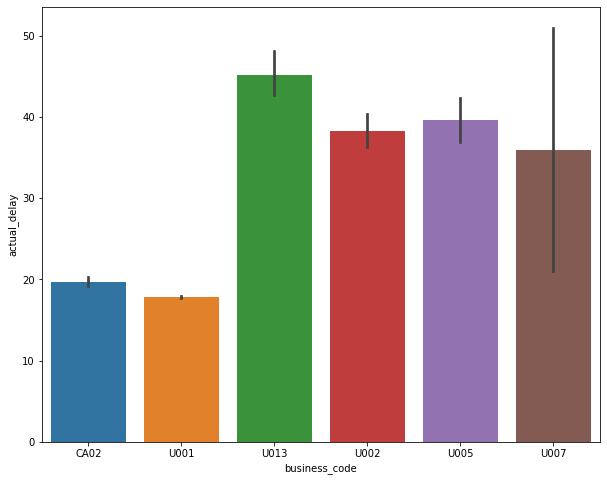

In [53]:
plt.figure(figsize=(10,8))
sns.barplot(x="business_code", y=y_train, data=X_train, linewidth=3)

##### We can see business code CA02 and U001 make less delay compared to other business code.
Also U007 have only 2 entries and its making almost same delay as U005, so I will club them together below.

<AxesSubplot:xlabel='cust_payment_terms', ylabel='actual_delay'>

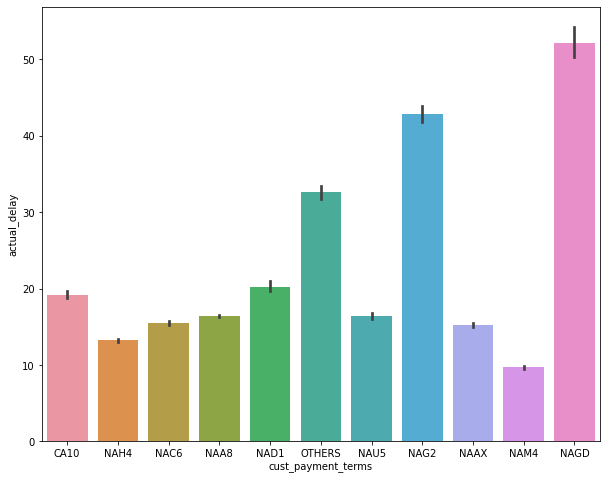

In [54]:
plt.figure(figsize=(10,8))
sns.barplot(x="cust_payment_terms", y=y_train, data=X_train, linewidth=3)

#### We can see others and NAGD payment_terms makes the most delay.

In [55]:
X_train['business_code'].value_counts()

U001    28860
CA02     2598
U013      429
U002       99
U005        9
U007        2
Name: business_code, dtype: int64

##### Clubbing U007 to U005.
And mapping the same changes to X_test and X_val.

In [56]:
X_train['business_code'] = np.where(X_train['business_code'].isin(['U001', 'CA02', 'U013', 'U002']), X_train['business_code'], 'U005')
X_test['business_code'] = np.where(X_test['business_code'].isin(['U001', 'CA02', 'U013', 'U002']), X_test['business_code'], 'U005')
X_val['business_code'] = np.where(X_val['business_code'].isin(['U001', 'CA02', 'U013', 'U002']), X_val['business_code'], 'U005')

##### Here i am doing label encoding of business_code.
So the same I have to map it to test and val set.
Since our model doesn't accept string values, label encoding will allow us categorize string data into labels according to its own occurence. 

In [57]:
#label encoding of business_code

business_code_enc = LabelEncoder()
X_train['business_code_enc'] = business_code_enc.fit_transform(X_train['business_code'])
X_test['business_code_enc'] = business_code_enc.fit_transform(X_test['business_code'])
X_val['business_code_enc'] = business_code_enc.fit_transform(X_val['business_code'])


##### Here I am lable encoding cust_payment_terms.
Similarly, I have to map these to test and val set.

In [58]:
#label encoding of cust_paymnet_terms

pay_terms_enc = LabelEncoder()
X_train['pay_terms_enc'] = pay_terms_enc.fit_transform(X_train['cust_payment_terms'])
X_test['pay_terms_enc'] = pay_terms_enc.fit_transform(X_test['cust_payment_terms'])
X_val['pay_terms_enc'] = pay_terms_enc.fit_transform(X_val['cust_payment_terms'])

##### As mentioned earlier I tried making a feature out of this column.
But later I realized that we dont have access to clear_date column in the main_test dataset. So i had to drop this feature.

In [59]:
#label encoding of age_bucket

# age_bucket_enc = LabelEncoder()
# X_train['age_bucket_enc'] = age_bucket_enc.fit_transform(X_train['age_bucket'])
# X_test['age_bucket_enc'] = age_bucket_enc.fit_transform(X_test['age_bucket'])
# X_val['age_bucket_enc'] = age_bucket_enc.fit_transform(X_val['age_bucket'])

In [60]:
X_train.head()

,business_code,cust_number,clear_date,buisness_year,posting_date,doc_create_date,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,expected_delay,business_code_enc,pay_terms_enc
0,CA02,0140104423,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190113.0,CAD,23464.08,CA10,2.960520e+09,2019-01-15,2019-01-13,2018-12-30,14,0,0
1,U001,0200769623,2019-01-10 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,1451.69,NAH4,1.928544e+09,2019-01-10,2019-01-14,2018-12-30,15,1,7
2,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,12190.97,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,15,1,7
3,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,20718.81,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,15,1,7
4,U001,0200762301,2019-01-15 00:00:00,2019.0,2018-12-30,20181230,20190114.0,USD,3204.34,NAC6,1.928540e+09,2019-01-15,2019-01-14,2018-12-30,15,1,3


##### Here we can see invoice_currency has only two values.
So we can do binarization on it. So I did USD to 0 and CAD to 1 and mapped those changes to test and val set as well.

In [61]:
X_train['invoice_currency'] = X_train['invoice_currency'].map({'USD': 0,'CAD': 1})
X_test['invoice_currency'] = X_test['invoice_currency'].map({'USD': 0,'CAD': 1})
X_val['invoice_currency'] = X_val['invoice_currency'].map({'USD': 0,'CAD': 1})

##### Now here I am finding out features from date columns,
like the month and day when the invoice was issued.
Or the month, day and day of the week, the invoice is due.
Mapping these features to test and val set as well.

In [62]:
X_train['doc_create_date'] = pd.to_datetime(X_train.doc_create_date)
#X_train['clear_month'] = X_train['clear_date_pd'].dt.month
X_train['issue_month'] = X_train['doc_create_date'].dt.month
X_train['issue_day'] = X_train['doc_create_date'].dt.day
X_train['due_month'] = X_train['due_date_pd'].dt.month
X_train['due_dayofweek'] = X_train['due_date_pd'].dt.dayofweek
X_train['due_day'] = X_train['due_date_pd'].dt.day

X_test['doc_create_date'] = pd.to_datetime(X_test.doc_create_date)
X_test['issue_month'] = X_test['doc_create_date'].dt.month
X_test['issue_day'] = X_test['doc_create_date'].dt.day
X_test['due_month'] = X_test['due_date_pd'].dt.month
X_test['due_dayofweek'] = X_test['due_date_pd'].dt.dayofweek
X_test['due_day'] = X_test['due_date_pd'].dt.day

X_val['doc_create_date'] = pd.to_datetime(X_val.doc_create_date)
X_val['issue_month'] = X_val['doc_create_date'].dt.month
X_val['issue_day'] = X_val['doc_create_date'].dt.day
X_val['due_month'] = X_val['due_date_pd'].dt.month
X_val['due_dayofweek'] = X_val['due_date_pd'].dt.dayofweek
X_val['due_day'] = X_val['due_date_pd'].dt.day

<AxesSubplot:xlabel='due_dayofweek', ylabel='actual_delay'>

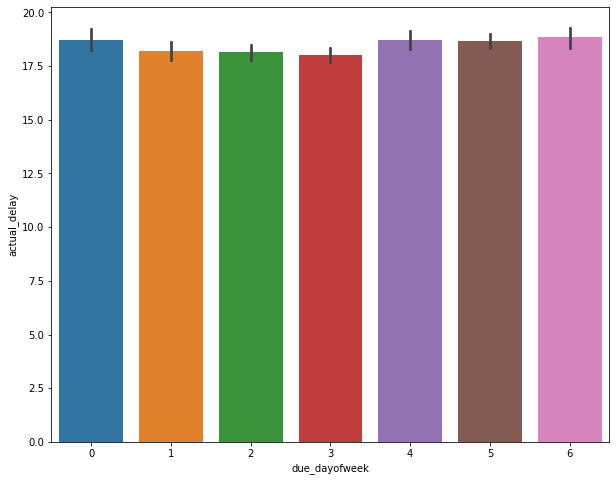

In [63]:
plt.figure(figsize=(10,8))
sns.barplot(x="due_dayofweek", y=y_train, data=X_train, linewidth=3)

#tried but couldn't infer much. 

<AxesSubplot:xlabel='due_month', ylabel='actual_delay'>

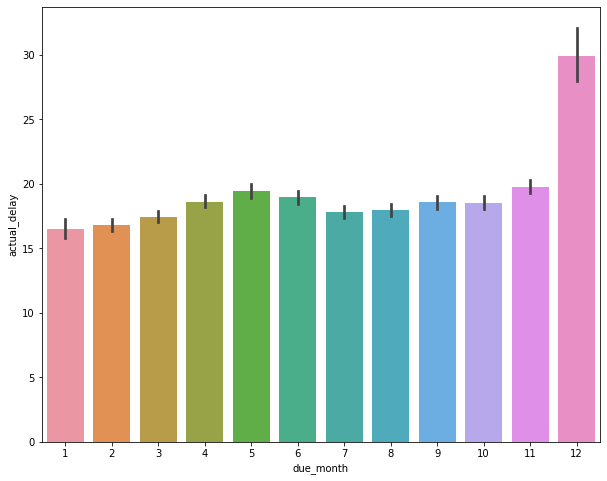

In [64]:
plt.figure(figsize=(10,8))
sns.barplot(x="due_month", y=y_train, data=X_train,linewidth=2.5)



##### It can be seen that customers delay most of their payment in the month of December.  

##### Plotting a heat map, to see correlation between remaining columns.

<AxesSubplot:>

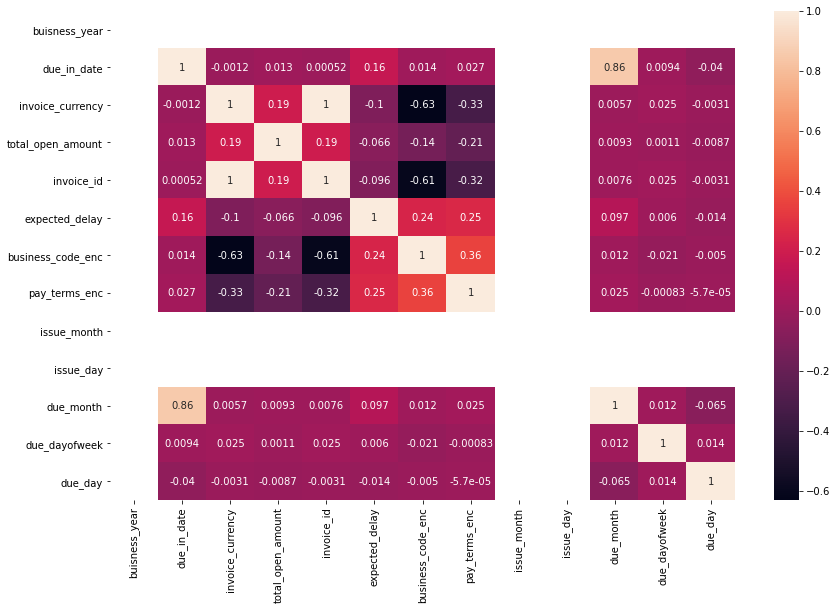

In [65]:
train=X_train.copy()
corr=train.corr()
plt.figure(figsize=(14,9))
sns.heatmap(corr,annot=True)

#### We can see the columns issue_month and issue_day are highly correlated
So we can drop them

In [66]:
X_train.head()

,business_code,cust_number,clear_date,buisness_year,posting_date,doc_create_date,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,clear_date_pd,due_date_pd,post_date_pd,expected_delay,business_code_enc,pay_terms_enc,issue_month,issue_day,due_month,due_dayofweek,due_day
0,CA02,0140104423,2019-01-15 00:00:00,2019.0,2018-12-30,1970-01-01 00:00:00.020181230,20190113.0,1,23464.08,CA10,2.960520e+09,2019-01-15,2019-01-13,2018-12-30,14,0,0,1,1,1,6,13
1,U001,0200769623,2019-01-10 00:00:00,2019.0,2018-12-30,1970-01-01 00:00:00.020181230,20190114.0,0,1451.69,NAH4,1.928544e+09,2019-01-10,2019-01-14,2018-12-30,15,1,7,1,1,1,0,14
2,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,1970-01-01 00:00:00.020181230,20190114.0,0,12190.97,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,15,1,7,1,1,1,0,14
3,U001,0200769623,2019-01-15 00:00:00,2019.0,2018-12-30,1970-01-01 00:00:00.020181230,20190114.0,0,20718.81,NAH4,1.928541e+09,2019-01-15,2019-01-14,2018-12-30,15,1,7,1,1,1,0,14
4,U001,0200762301,2019-01-15 00:00:00,2019.0,2018-12-30,1970-01-01 00:00:00.020181230,20190114.0,0,3204.34,NAC6,1.928540e+09,2019-01-15,2019-01-14,2018-12-30,15,1,3,1,1,1,0,14


#### Now droping the remaining columns.
Only keeping the features columns in all train, test and val set.

In [67]:
X_train.drop(["business_code",'cust_number', 'clear_date', 'buisness_year', 'posting_date', 
              'issue_month', 'doc_create_date', 'post_date_pd',
              'due_in_date', 'cust_payment_terms', 'invoice_id', 'due_date_pd',
              'total_open_amount', 'clear_date_pd'], axis=1,inplace=True)

In [68]:
X_test.drop(["business_code",'cust_number', 'clear_date', 'buisness_year', 'posting_date', 
              'issue_month', 'doc_create_date', 'post_date_pd',
              'due_in_date', 'cust_payment_terms', 'invoice_id', 'due_date_pd',
              'total_open_amount', 'clear_date_pd'], axis=1,inplace=True)

In [69]:
X_val.drop(["business_code",'cust_number', 'clear_date', 'buisness_year', 'posting_date', 
              'issue_month', 'doc_create_date', 'post_date_pd',
              'due_in_date', 'cust_payment_terms', 'invoice_id', 'due_date_pd',
              'total_open_amount', 'clear_date_pd'], axis=1,inplace=True)

##### I tried the feature selection.
But here i didnt get any good results. Without feature selection, I was getting good accuracy so I decided not to go with feature selection.

In [70]:
def tree_based_feature_importance(x_train,y_train):
    from sklearn.ensemble import RandomForestRegressor
    # create the random forest model
    model = RandomForestRegressor(n_estimators=120)

    # fit the model to start training.
    model.fit(x_train, y_train)

    # get the importance of the resulting features.
    importances = model.feature_importances_

    # create a data frame for visualization.
    final_df = pd.DataFrame({"Features": x_train.columns, "Importances":importances})
    final_df.set_index('Importances')

    # sort in descending order 
    final_df = final_df.sort_values('Importances',ascending=False)
    
    #visualising feature importance
    pd.Series(model.feature_importances_, index=x_train.columns).nlargest(6).plot(kind='barh')  
    return final_df

In [71]:
X_train_new = X_train.copy()
X_test_new = X_test.copy()
X_val_new = X_val.copy()

# feature_importance=tree_based_feature_importance(X_train_new,y_train)
# display(feature_importance)

## Milestone 3 
Modelling

In [72]:
MSE_Score = []
R2_Score = []
Algorithm = []

In [73]:
X_train.head()

,invoice_currency,expected_delay,business_code_enc,pay_terms_enc,issue_day,due_month,due_dayofweek,due_day
0,1,14,0,0,1,1,6,13
1,0,15,1,7,1,1,0,14
2,0,15,1,7,1,1,0,14
3,0,15,1,7,1,1,0,14
4,0,15,1,3,1,1,0,14


### Linear Regression model

In [74]:
# Fitting Simple Linear Regression to the Training Set
Algorithm.append('Linear Regression')
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [75]:
# Predicting the Test Set Results
predicted_lr = clf.predict(X_test)
MSE_Score.append(mean_squared_error(y_test, predicted_lr))
R2_Score.append(r2_score(y_test, predicted_lr))

In [76]:
# Predicting the val Set Results
predicted_lr = clf.predict(X_val_new)
MSE_Score.append(mean_squared_error(y_val, predicted_lr))
R2_Score.append(r2_score(y_val, predicted_lr))

### Random Forest Regressor model

In [77]:
# Fitting Random Forest Regressor Tree to the Training Set
Algorithm.append('Random Forest Regressor')
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
# Predicting the Test Set Results
predicted_RFR = clf.predict(X_test)
MSE_Score.append(mean_squared_error(y_test, predicted_RFR))
R2_Score.append(r2_score(y_test, predicted_RFR))

In [79]:
# Predicting the Val Set Results
predicted_RFR = clf.predict(X_val)
MSE_Score.append(mean_squared_error(y_val, predicted_RFR))
R2_Score.append(r2_score(y_val, predicted_RFR))

### XGB Regressor model
Using hyperparameters tuning max_depth = 5

In [122]:
# Fitting XGBoost Regressor to the Training Set
Algorithm.append('XGB Regressor')
clf_xgb = xgb.XGBRegressor(max_depth=5)
clf_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# Predicting the Test Set Results
predicted_XGB = clf_xgb.predict(X_test)
MSE_Score.append(mean_squared_error(y_test, predicted_XGB))
R2_Score.append(r2_score(y_test, predicted_XGB))

In [124]:
# Predicting the Val Set Results
predicted_XGB = clf_xgb.predict(X_val)
MSE_Score.append(mean_squared_error(y_val, predicted_XGB))
R2_Score.append(r2_score(y_val, predicted_XGB))

### Support Vector Regressor model

In [83]:
# Fitting SVR to the Training Set
Algorithm.append('Support Vector Regression')
clf = SVR()
clf.fit(X_train, y_train)

SVR()

In [84]:
# Predicting the Test Set Results
predicted_svr = clf.predict(X_test)
MSE_Score.append(mean_squared_error(y_test, predicted_svr))
R2_Score.append(r2_score(y_test, predicted_svr))

In [85]:
# Predicting the Test Set Results
predicted_svr = clf.predict(X_val)
MSE_Score.append(mean_squared_error(y_val, predicted_svr))
R2_Score.append(r2_score(y_val, predicted_svr))

### Decision Tree Regressor model

In [86]:
# Fitting Decision Tree to the Training Set
Algorithm.append('Decision Tree Regressor')
clf_dtr = DecisionTreeRegressor()
clf_dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [87]:
predicted_dtr = clf_dtr.predict(X_test)
MSE_Score.append(mean_squared_error(y_test, predicted_dtr))
R2_Score.append(r2_score(y_test, predicted_dtr))

In [88]:
predicted_dtr = clf_dtr.predict(X_val)
MSE_Score.append(mean_squared_error(y_val, predicted_dtr))
R2_Score.append(r2_score(y_val, predicted_dtr))

In [125]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])

In [126]:
Comparison

,Algorithm,MSE_Score,R2_Score
0,Linear Regression,83.628447,0.373454
1,Random Forest Regressor,51.165393,0.175760
2,XGB Regressor,69.445018,0.479717
3,Support Vector Regression,42.291661,0.318709
4,Decision Tree Regressor,69.934149,0.476052
5,XGB Regressor,44.574726,0.281931


### Out of all these 5 models,
I found out that XGB Regressor model and Support Vector Regression model gives the best results. Although MSE of XGB regressor is slightly higher than svr, I have used hyperparameter tunings in this model. So I am gonna use this model.

In [128]:
main_test = pd.read_csv("final_test.csv")
main_test.shape
df = pd.DataFrame(main_test)
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1


### Maping the features to this main test data

In [129]:
df['due_date_pd'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['post_date_pd'] = pd.to_datetime(df['posting_date'])

df['expected_delay'] = df['due_date_pd'] - df['post_date_pd']

df['expected_delay'] = df.expected_delay.astype('timedelta64[D]').astype(int)

In [130]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date_pd,post_date_pd,expected_delay
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1,2020-04-10,2020-03-26,15
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1,2020-04-30,2020-04-15,15
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1,2020-04-02,2020-03-18,15
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1,2020-04-19,2020-04-04,15
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1,2020-04-12,2020-03-28,15


In [131]:
df['cust_payment_terms'].value_counts()

NAA8    4097
NAH4    3057
CA10     687
NAC6     407
NAGD     292
NAM4     271
NAAX     226
NAU5     213
NAD1     106
NAG2      93
NAM2      89
NA32      79
NA10      69
NAX2      57
NAD5      54
NAVE      42
NAM1      34
NAAW      31
NAVF      20
NAWP      17
NABG       9
NAM3       6
NAVQ       5
NAB1       5
NA3B       5
NACB       4
NA38       3
NAUZ       3
NACH       3
NAVD       3
NA84       2
C106       2
NA3F       2
NACE       1
90M7       1
CAX2       1
CA30       1
NAD4       1
NACG       1
NA25       1
Name: cust_payment_terms, dtype: int64

In [132]:
df['cust_payment_terms'] = np.where(df['cust_payment_terms']
                                .isin(["B112", "BR60", "NAV9", "NATM", "NAWM", "NANC", "NATU", "NA31"
                                , "NACH", "NACG", "NACE", "NAG2", "NAD1"
                                , "NATK", "C129", "NA24", "NAUW", "BR12", "NAV2", "NATL", "CA60", "NA25"
                                , "NAUN", "NATV", "NATX", "CAX2", "NATH", "NAUI", "90M7", "NAM3", "NAD8"
                                , "NATZ", "NAUP", "NAVC", "CAB1", "NAVD", "BR56", "NAVL", "NA8Q", "NA3F"
                                , "NAD4", "NA9X", "C106", "NA84", "NAB1", "NATW", "NA38", "NACB", "NABG"
                                , "CA30", "NA3B", "NAUZ", "NAVM", "NAWN", "NAVQ", "NAWP", "NAVR", "NAWU"
                                , "NAAW", "NAVF", "NAD5", "NA10", "NAM2", "NAX2", "NA32", "NAM1", "NAVE"])
                                ,"OTHERS", 
                                df['cust_payment_terms'])

In [133]:
df['business_code'].value_counts()

U001    9218
CA02     692
U013      70
U002      15
U005       4
U007       1
Name: business_code, dtype: int64

In [134]:
df['business_code'] = np.where(df['business_code'].isin(['U001', 'CA02', 'U013', 'U002']), df['business_code'], 'U005')

In [135]:
df['business_code_enc'] = business_code_enc.fit_transform(df['business_code'])

In [136]:
df['pay_terms_enc'] = pay_terms_enc.fit_transform(df['cust_payment_terms'])

In [137]:
df['invoice_currency'] = df['invoice_currency'].map({'USD': 0,'CAD': 1})

In [138]:
df = df.rename(columns= {'document type': 'doc_type'} )
df = df.rename(columns= {'document_create_date.1': 'doc_create_date'} )

In [139]:
df['doc_create_date'] = pd.to_datetime(df.doc_create_date, format='%Y%m%d')
df['issue_month'] = df['doc_create_date'].dt.month
df['issue_day'] = df['doc_create_date'].dt.day
df['due_month'] = df['due_date_pd'].dt.month
df['due_dayofweek'] = df['due_date_pd'].dt.dayofweek
df['due_day'] = df['due_date_pd'].dt.day

##### Now I have mapped all features into the main test set.
Now droping the remaining columns.

In [140]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,doc_create_date,due_in_date,invoice_currency,doc_type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date_pd,post_date_pd,expected_delay,business_code_enc,pay_terms_enc,issue_month,issue_day,due_month,due_dayofweek,due_day
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,2020-03-26,20200410.0,0,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1,2020-04-10,2020-03-26,15,1,5,3,26,4,4,10
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,2020-04-15,20200430.0,0,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1,2020-04-30,2020-04-15,15,1,5,4,15,4,3,30
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,2020-03-18,20200402.0,0,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1,2020-04-02,2020-03-18,15,1,1,3,18,4,3,2
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,2020-04-04,20200419.0,0,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1,2020-04-19,2020-04-04,15,1,1,4,4,4,6,19
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,2020-03-28,20200412.0,0,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1,2020-04-12,2020-03-28,15,1,5,3,28,4,6,12


In [141]:
df.drop(["business_code",'cust_number', 'name_customer', 'clear_date', 'buisness_year', 'posting_date', 
              'issue_month', 'document_create_date', 'doc_create_date', 'post_date_pd', 'doc_id', 'posting_date',
              'due_in_date', 'cust_payment_terms', 'posting_id', 'invoice_id', 'due_date_pd', 'doc_type',
              'area_business', 'baseline_create_date', 'isOpen', 'due_date_pd', 'issue_month',
              'total_open_amount'], axis=1,inplace=True)

#### Using the XGB regressor model to predict final results.

In [142]:
predicted_xgb = clf_xgb.predict(df)

In [143]:
YY_test = pd.DataFrame(predicted_xgb)
test = YY_test.to_csv("output.csv")
YY_test.head()

,0
0,15.814985
1,15.776838
2,16.426659
3,16.381006
4,15.295620


In [144]:
YY_test.dtypes

0    float32
dtype: object

##### Now we have got our predicted dates. Now we can get predicted clear_date which i will store in pred_payment_date column

In [145]:
df = pd.read_csv("final_test.csv")
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1


##### We can see above that the predicted days is in float datatype

In [146]:
YY_test['expected_delay'] = YY_test.astype(int)
YY_test['expected_delay'] = np.round(YY_test['expected_delay'])
df['post_date_pd'] = pd.to_datetime(df['posting_date'])
df['pred_pay_day'] = YY_test.expected_delay.astype('timedelta64[D]')

In [147]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,post_date_pd,pred_pay_day
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1,2020-03-26,15 days
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1,2020-04-15,15 days
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1,2020-03-18,16 days
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1,2020-04-04,16 days
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1,2020-03-28,15 days


##### Adding the number of days to due_date will give us the pred_payment_date.

In [148]:
df['pred_payment_date'] = df['post_date_pd'] + df['pred_pay_day']

In [149]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,post_date_pd,pred_pay_day,pred_payment_date
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1,2020-03-26,15 days,2020-04-10
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1,2020-04-15,15 days,2020-04-30
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1,2020-03-18,16 days,2020-04-03
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1,2020-04-04,16 days,2020-04-20
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1,2020-03-28,15 days,2020-04-12


In [150]:
df.dtypes

business_code                      object
cust_number                        object
name_customer                      object
clear_date                        float64
buisness_year                     float64
doc_id                            float64
posting_date                       object
document_create_date                int64
document_create_date.1              int64
due_in_date                       float64
invoice_currency                   object
document type                      object
posting_id                        float64
area_business                     float64
total_open_amount                 float64
baseline_create_date              float64
cust_payment_terms                 object
invoice_id                        float64
isOpen                              int64
post_date_pd               datetime64[ns]
pred_pay_day              timedelta64[ns]
pred_payment_date          datetime64[ns]
dtype: object

##### Finding the predicted delay.
Creating the age_bucket column using this delay

In [151]:
df['due_date_pd'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')

##### Subtracting the due date from pred_payment_date will give us delay in days

In [152]:
df['delay'] = df['pred_payment_date'] - df['due_date_pd']

##### Converting delay in days to int.
To convert into int, we need to first convert days in timdelta format, then to int.

In [153]:
df['delay'] = df.delay.astype('timedelta64[D]').astype(int)

##### Converting the negative delay to 0.
Because negative number of days implies payment was completed before due date.

In [154]:
#df['delay'] = np.where(df.delay.lt(0), 0, df.delay) #neg values to 0

##### Binning the delays into categories.
Cleared, 0-15 days, 16-30 days, 31-45 days, 46-60 days, Greater than 60 days.

In [160]:
bins = [-500, -1,15,30,45,60, 1000]   #6 elements
category = ["Cleared", "0-15 days", "16-30 days", "31-45 days", "46-60 days", "Greater than 60 days"]  #5 elements
df['age_bucket'] = pd.cut(df["delay"],bins,labels = category)

##### There are few NaN values in age_bucket, so filling it up with 0-15 days category

In [161]:
df["age_bucket"].fillna('0-15 days', inplace = True)

##### Converting the age_bucket columns to string

In [162]:
df['age_bucket'] = df.age_bucket.astype(str)

In [164]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,post_date_pd,pred_pay_day,pred_payment_date,due_date_pd,delay,age_bucket
0,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930701e+09,2020-03-26,20200325,20200326,20200410.0,USD,RV,1.0,NaN,16502.49,20200326.0,NAH4,1.930701e+09,1,2020-03-26,15 days,2020-04-10,2020-04-10,0,0-15 days
1,U001,0200769623,WAL-MAR corporation,NaN,2020.0,1.930769e+09,2020-04-15,20200409,20200415,20200430.0,USD,RV,1.0,NaN,433.51,20200415.0,NAH4,1.930769e+09,1,2020-04-15,15 days,2020-04-30,2020-04-30,0,0-15 days
2,U001,0200434439,BAUGH SU corp,NaN,2020.0,1.930657e+09,2020-03-18,20200316,20200318,20200402.0,USD,RV,1.0,NaN,29664.77,20200318.0,NAA8,1.930657e+09,1,2020-03-18,16 days,2020-04-03,2020-04-02,1,0-15 days
3,U001,0200739534,OK corp,NaN,2020.0,1.930746e+09,2020-04-04,20200404,20200404,20200419.0,USD,RV,1.0,NaN,73924.15,20200404.0,NAA8,1.930746e+09,1,2020-04-04,16 days,2020-04-20,2020-04-19,1,0-15 days
4,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930708e+09,2020-03-28,20200326,20200328,20200412.0,USD,RV,1.0,NaN,15453.27,20200328.0,NAH4,1.930708e+09,1,2020-03-28,15 days,2020-04-12,2020-04-12,0,0-15 days


In [ ]:
df.to_csv("output.csv")

# End 